<a href="https://colab.research.google.com/github/namita0210/Text-Sentiment-Classifier/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
from kagglehub import dataset_download
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from scipy.sparse import hstack
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # It uses the perceptron algorithm to assign parts of speech to words based on context.
nltk.download('punkt') # for tokenizing text to words or sentences
nltk.download('stopwords') # populary removed words
nltk.download('wordnet') #dictionary of words to reduce them to their base form : lemmatize
nltk.download('averaged_perceptron_tagger')  # For POS tagging
print("Done")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Done


In [8]:
# Download latest version
path = dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

100%|██████████| 1.99M/1.99M [00:01<00:00, 1.10MB/s]

Extracting files...
Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [9]:
train_df = pd.read_csv(path + '/twitter_training.csv' , header = None)
val_df = pd.read_csv(path + '/twitter_validation.csv', header = None)
train_df.columns = ['id','title','sentiment','text']
val_df.columns = ['id','title','sentiment','text']

In [14]:
print(f'''Train Df Shape :{train_df.shape}
Validation Df Shape :{val_df.shape}''')

Train Df Shape :(74682, 4)
Validation Df Shape :(1000, 4)


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   title      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [18]:
train_df.dropna(subset=['text'], inplace=True)

In [19]:
train_df.head(2)

,id,title,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [21]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   title      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [20]:
val_df.head(2)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [22]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

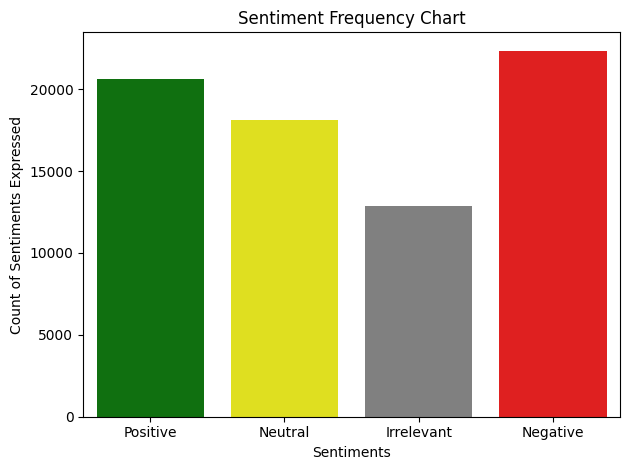

In [24]:
color = {'Positive':'Green', 'Neutral':'Yellow', 'Irrelevant':'Grey','Negative':'Red'}

sns.countplot(x='sentiment', data=train_df
              ,order=['Positive','Neutral','Irrelevant','Negative']
              ,hue='sentiment'
              ,legend=False
              ,palette=color)
plt.xlabel('Sentiments')
plt.ylabel('Count of Sentiments Expressed')
plt.title('Sentiment Frequency Chart')
plt.tight_layout()
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))
lm = lemmy()

def clean(text):
    text=text.lower() #lowercase

    no_punct = re.sub(r'[^a-z\s]','',text) #remove punctuation, digits

    words = word_tokenize(no_punct) #split text into words, returns a list

    words = [i for i in words if i not in stop_words] #remove stopwords

    pos_tags = nltk.pos_tag(words) # returns a tuple (word, pos tag)
    words = [
    lm.lemmatize(word, pos='v') if tag.startswith('V') else  # If tag starts with 'V', treat as verb
    lm.lemmatize(word, pos='n') if tag.startswith('N') else  # If tag starts with 'N', treat as noun
    lm.lemmatize(word, pos='a') if tag.startswith('R') else  # If tag starts with 'R', treat as adjective/adverb
    lm.lemmatize(word)  # Default to noun if no match
    for word, tag in pos_tags
    ] #lemmatize returns a string

    clean_words = ' '.join(words) # joins the words in the list seperated by a space

    return clean_words

In [13]:
train_df['text']=train_df['text'].apply(clean)

In [14]:
train_df

,id,title,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder
...,...,...,...,...
74677,9200,Nvidia,Positive,realize window partition mac like year behind ...
74678,9200,Nvidia,Positive,realize mac window partition year behind nvidi...
74679,9200,Nvidia,Positive,realize window partition mac year behind nvidi...
74680,9200,Nvidia,Positive,realize window partition mac like year behind ...


In [38]:
train_df['text']=train_df['text'].apply(word_tokenize)

In [16]:
vectorizer = TfidfVectorizer()

In [17]:
X = vectorizer.fit_transform(train_df['text'])

In [18]:
X

<73996x34526 sparse matrix of type '<class 'numpy.float64'>'
	with 743446 stored elements in Compressed Sparse Row format>

In [34]:
type(X)

scipy.sparse._csr.csr_matrix

In [35]:
print(X)

  (0, 14111)	0.3596450088186696
  (0, 11120)	0.3141815004193741
  (0, 3369)	0.4882627301386867
  (0, 18983)	0.7304416190111062
  (1, 5303)	0.429303324399671
  (1, 3367)	0.7531625149777598
  (1, 15892)	0.49844245574766877
  (2, 14111)	0.4242645436030371
  (2, 11120)	0.37063233915516414
  (2, 3369)	0.5759917676630613
  (2, 15892)	0.5923383744094753
  (3, 14111)	0.34474311825658266
  (3, 3369)	0.46803156442899924
  (3, 18983)	0.7001757712957407
  (3, 5303)	0.4145509937309115
  (4, 14111)	0.3596450088186696
  (4, 11120)	0.3141815004193741
  (4, 3369)	0.4882627301386867
  (4, 18983)	0.7304416190111062
  (5, 14111)	0.3596450088186696
  (5, 11120)	0.3141815004193741
  (5, 3369)	0.4882627301386867
  (5, 18983)	0.7304416190111062
  (6, 3369)	0.14965454852918428
  (6, 27506)	0.21403659779649029
  :	:
  (73993, 21156)	0.44608694946484423
  (73994, 16710)	0.15422037969416202
  (73994, 33691)	0.18570713967163852
  (73994, 10558)	0.16632879115002533
  (73994, 8944)	0.20183599547291814
  (73994, 2423

Most of the elements in a TF-IDF matrix are typically zero (because most words don't appear in most documents).  Storing all those zeros would be extremely inefficient.  Sparse matrix formats like COO, Compressed Sparse Row (CSR), and Compressed Sparse Column (CSC) only store the non-zero values and their indices, saving a huge amount of memory.

In [39]:
tf_idf_matrix = X

In [19]:
sentiment_map = {
    'Positive': 3,
    'Neutral': 1,
    'Irrelevant': 2,
    'Negative': 0
}

In [20]:
train_df['sentiment'] = train_df['sentiment'].map(sentiment_map)

In [21]:
len(train_df['title'].unique())

32

In [22]:
le = LabelEncoder()
train_df['title'] = le.fit_transform(train_df['title'])

In [40]:
train_df.head(2)

,id,title,sentiment,text
0,2401,4,3,"[im, get, borderland, murder]"
1,2401,4,3,"[come, border, kill]"


In [42]:
target = train_df['sentiment']

In [64]:
independent_variables = ['id','title']
features = train_df[independent_variables].values

In [60]:
features.values

array([[2401,    4],
       [2401,    4],
       [2401,    4],
       ...,
       [9200,   21],
       [9200,   21],
       [9200,   21]])

In [62]:
print(f'''dimension = {features.values.ndim}
shape = {features.values.shape}''')

dimension = 2
shape = (73996, 2)


In [58]:
print(f'''dimension = {tf_idf_matrix.ndim}
shape = {tf_idf_matrix.shape}''')

dimension = 2
shape = (73996, 34526)


In [66]:
features = hstack((features,tf_idf_matrix))

In [67]:
features

<73996x34528 sparse matrix of type '<class 'numpy.float64'>'
	with 889162 stored elements in COOrdinate format>

#Training a neural network to predict the sentiment based on the independent variables in my dataframe.

In [70]:
num_categories = features.shape[1]
print(num_categories)

34528


In [71]:
embedding_dim = 5

In [72]:
nn = Sequential()

In [73]:
nn.add(Embedding(input_dim=num_categories,  # 32 categories
                    output_dim=embedding_dim,  # Dimension of the embedding vector (e.g., 5)
                    input_length=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [74]:
nn.add(Flatten())

In [75]:
nn.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
nn.add(Dense(32, activation='relu'))

In [76]:
nn.add(Dense(4, activation='softmax'))  # Output layer with 4 classes (0-3)

In [77]:
# Compile the model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [78]:
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
nn.fit(features, target, epochs=10, batch_size=32)

Epoch 1/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 701s 302ms/step - accuracy: 0.2695 - loss: 7.2092
Epoch 2/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 743s 302ms/step - accuracy: 0.3750 - loss: 2.7159
Epoch 3/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 704s 286ms/step - accuracy: 0.3058 - loss: 1.3656
Epoch 4/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 668s 289ms/step - accuracy: 0.3026 - loss: 1.3662
Epoch 5/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 691s 299ms/step - accuracy: 0.3025 - loss: 1.3678
Epoch 6/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 644s 279ms/step - accuracy: 0.2996 - loss: 1.3679
Epoch 7/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 702s 304ms/step - accuracy: 0.3034 - loss: 1.3674
Epoch 8/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 687s 297ms/step - accuracy: 0.2987 - loss: 1.3674
Epoch 9/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 686s 297ms/step - accuracy: 0.3018 - loss: 1.3672
Epoch 10/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 747s 299ms/step - accuracy: 0.3007 - loss: 1.3673


In [2]:
import numpy as np

A = np.random.randn(3,4)
B = np.random.randn(4,3)

print(f''' A : {type(A)}
      B:  {type(B)}
      A multiplied by B : {A@B}''')

 A : <class 'numpy.ndarray'>
      B:  <class 'numpy.ndarray'>
      A multiplied by B : [[ 2.1524762  -0.52164316  1.19352793]
 [-0.5041541   0.55134038  2.6502013 ]
 [-0.58687291  0.04682675 -3.08522822]]
